<a href="https://colab.research.google.com/github/madaime2/Novel_Pollen_Phylogenetic_Placement/blob/main/03_Fossil_Analysis/00_Phylogenetic_Placement_Fossil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

absolute_path = os.path.dirname("/content/drive/MyDrive/Podocarpus_Final/Podocarpus_Project/")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Load Concatenated features (CNN-learned features across three modalities) for both the known and unknown specimens
import pandas as pd 
df_Features_Known = pd.read_csv(absolute_path + "/Concatenated_Features_Three_Modalities_Known.csv", header = None)
df_Features_Unknown = pd.read_csv(absolute_path + "/Feature_vector_specimen_Panama_4.25.csv", header = None)

In [6]:
import torch
import numpy as np

# Pairwise (species-level) Distance Matrix 

# C represents the distance matrix depicting the "ground-truth" inter-class distances (i.e. the phylogenetic distances separating all *known* taxa)
# These are the classes (taxa) known to the model. 

# Podocarpus cophenetic distance patrix (all taxa)

C = np.array([
    [0,99.79615,63.13772,99.79615,63.13772,99.79615,99.79615,63.13772,99.79615,30.05496,63.13772,30.05496,99.79615,99.79615,63.13772,63.13772,99.79615,30.05496,99.79615,63.13772,63.13772,63.13772,99.79615,99.79615,72.74426,63.13772,99.79615,99.79615,12.58331,63.13772],
    [99.79615,0,99.79615,36.20694,99.79615,65.49675,49.15364,99.79615,65.49675,99.79615,99.79615,99.79615,49.15364,28.1985,99.79615,99.79615,42.4938,99.79615,49.15364,99.79615,99.79615,99.79615,28.1985,49.15364,99.79615,99.79615,65.49675,49.15364,99.79615,99.79615],
    [63.13772,99.79615,0,99.79615,15.93869,99.79615,99.79615,52.67842,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,33.41821,52.67842,99.79615,63.13772,99.79615,58.99733,25.55484,58.99733,99.79615,99.79615,72.74426,15.93869,99.79615,99.79615,63.13772,25.55484],
    [99.79615,36.20694,99.79615,0,99.79615,65.49675,49.15363,99.79615,65.49675,99.79615,99.79615,99.79615,49.15363,36.20694,99.79615,99.79615,42.4938,99.79615,49.15363,99.79615,99.79615,99.79615,36.20694,49.15363,99.79615,99.79615,65.49675,49.15363,99.79615,99.79615],
    [63.13772,99.79615,15.93869,99.79615,0,99.79615,99.79615,52.67842,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,33.41821,52.67842,99.79615,63.13772,99.79615,58.99733,25.55484,58.99733,99.79615,99.79615,72.74426,12.69516,99.79615,99.79615,63.13772,25.55484],
    [99.79615,65.49675,99.79615,65.49675,99.79615,0,65.49675,99.79615,32.59701,99.79615,99.79615,99.79615,65.49675,65.49675,99.79615,99.79615,65.49675,99.79615,65.49675,99.79615,99.79615,99.79615,65.49675,65.49675,99.79615,99.79615,32.59701,65.49675,99.79615,99.79615],
    [99.79615,49.15364,99.79615,49.15363,99.79615,65.49675,0,99.79615,65.49675,99.79615,99.79615,99.79615,28.27449,49.15363,99.79615,99.79615,49.15364,99.79615,28.27449,99.79615,99.79615,99.79615,49.15363,10.13461,99.79615,99.79615,65.49675,28.27449,99.79615,99.79615],
    [63.13772,99.79615,52.67842,99.79615,52.67842,99.79615,99.79615,0,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,52.67842,12.04249,99.79615,63.13772,99.79615,58.99733,52.67842,58.99733,99.79615,99.79615,72.74426,52.67842,99.79615,99.79615,63.13772,52.67842],
    [99.79615,65.49675,99.79615,65.49675,99.79615,32.59701,65.49675,99.79615,0,99.79615,99.79615,99.79615,65.49675,65.49675,99.79615,99.79615,65.49675,99.79615,65.49675,99.79615,99.79615,99.79615,65.49675,65.49675,99.79615,99.79615,2.84746,65.49675,99.79615,99.79615],
    [30.05496,99.79615,63.13772,99.79615,63.13772,99.79615,99.79615,63.13772,99.79615,0,63.13772,7.36035,99.79615,99.79615,63.13772,63.13772,99.79615,14.47632,99.79615,63.13772,63.13772,63.13772,99.79615,99.79615,72.74426,63.13772,99.79615,99.79615,30.05496,63.13772],
    [63.13772,99.79615,58.99733,99.79615,58.99733,99.79615,99.79615,58.99733,99.79615,63.13772,0,63.13772,99.79615,99.79615,58.99733,58.99733,99.79615,63.13772,99.79615,51.13068,58.99733,23.76483,99.79615,99.79615,72.74426,58.99733,99.79615,99.79615,63.13772,58.99733],
    [30.05496,99.79615,63.13772,99.79615,63.13772,99.79615,99.79615,63.13772,99.79615,7.36035,63.13772,0,99.79615,99.79615,63.13772,63.13772,99.79615,14.47632,99.79615,63.13772,63.13772,63.13772,99.79615,99.79615,72.74426,63.13772,99.79615,99.79615,30.05496,63.13772],
    [99.79615,49.15364,99.79615,49.15363,99.79615,65.49675,28.27449,99.79615,65.49675,99.79615,99.79615,99.79615,0,49.15363,99.79615,99.79615,49.15364,99.79615,20.10967,99.79615,99.79615,99.79615,49.15363,28.27449,99.79615,99.79615,65.49675,7.82913,99.79615,99.79615],
    [99.79615,28.1985,99.79615,36.20694,99.79615,65.49675,49.15363,99.79615,65.49675,99.79615,99.79615,99.79615,49.15363,0,99.79615,99.79615,42.4938,99.79615,49.15363,99.79615,99.79615,99.79615,5.34205,49.15363,99.79615,99.79615,65.49675,49.15363,99.79615,99.79615],
    [63.13772,99.79615,33.41821,99.79615,33.41821,99.79615,99.79615,52.67842,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,0,52.67842,99.79615,63.13772,99.79615,58.99733,33.41822,58.99733,99.79615,99.79615,72.74426,33.41821,99.79615,99.79615,63.13772,33.41821],
    [63.13772,99.79615,52.67842,99.79615,52.67842,99.79615,99.79615,12.04249,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,52.67842,0,99.79615,63.13772,99.79615,58.99733,52.67842,58.99733,99.79615,99.79615,72.74426,52.67842,99.79615,99.79615,63.13772,52.67842],
    [99.79615,42.4938,99.79615,42.4938,99.79615,65.49675,49.15364,99.79615,65.49675,99.79615,99.79615,99.79615,49.15364,42.4938,99.79615,99.79615,0,99.79615,49.15364,99.79615,99.79615,99.79615,42.4938,49.15364,99.79615,99.79615,65.49675,49.15364,99.79615,99.79615],
    [30.05496,99.79615,63.13772,99.79615,63.13772,99.79615,99.79615,63.13772,99.79615,14.47632,63.13772,14.47632,99.79615,99.79615,63.13772,63.13772,99.79615,0,99.79615,63.13772,63.13772,63.13772,99.79615,99.79615,72.74426,63.13772,99.79615,99.79615,30.05496,63.13772],
    [99.79615,49.15364,99.79615,49.15363,99.79615,65.49675,28.27449,99.79615,65.49675,99.79615,99.79615,99.79615,20.10967,49.15363,99.79615,99.79615,49.15364,99.79615,0,99.79615,99.79615,99.79615,49.15363,28.27449,99.79615,99.79615,65.49675,20.10967,99.79615,99.79615],
    [63.13772,99.79615,58.99733,99.79615,58.99733,99.79615,99.79615,58.99733,99.79615,63.13772,51.13068,63.13772,99.79615,99.79615,58.99733,58.99733,99.79615,63.13772,99.79615,0,58.99733,51.13068,99.79615,99.79615,72.74426,58.99733,99.79615,99.79615,63.13772,58.99733],
    [63.13772,99.79615,25.55484,99.79615,25.55484,99.79615,99.79615,52.67842,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,33.41822,52.67842,99.79615,63.13772,99.79615,58.99733,0,58.99733,99.79615,99.79615,72.74426,25.55484,99.79615,99.79615,63.13772,22.27456],
    [63.13772,99.79615,58.99733,99.79615,58.99733,99.79615,99.79615,58.99733,99.79615,63.13772,23.76483,63.13772,99.79615,99.79615,58.99733,58.99733,99.79615,63.13772,99.79615,51.13068,58.99733,0,99.79615,99.79615,72.74426,58.99733,99.79615,99.79615,63.13772,58.99733],
    [99.79615,28.1985,99.79615,36.20694,99.79615,65.49675,49.15363,99.79615,65.49675,99.79615,99.79615,99.79615,49.15363,5.34205,99.79615,99.79615,42.4938,99.79615,49.15363,99.79615,99.79615,99.79615,0,49.15363,99.79615,99.79615,65.49675,49.15363,99.79615,99.79615],
    [99.79615,49.15364,99.79615,49.15363,99.79615,65.49675,10.13461,99.79615,65.49675,99.79615,99.79615,99.79615,28.27449,49.15363,99.79615,99.79615,49.15364,99.79615,28.27449,99.79615,99.79615,99.79615,49.15363,0,99.79615,99.79615,65.49675,28.27449,99.79615,99.79615],
    [72.74426,99.79615,72.74426,99.79615,72.74426,99.79615,99.79615,72.74426,99.79615,72.74426,72.74426,72.74426,99.79615,99.79615,72.74426,72.74426,99.79615,72.74426,99.79615,72.74426,72.74426,72.74426,99.79615,99.79615,0,72.74426,99.79615,99.79615,72.74426,72.74426],
    [63.13772,99.79615,15.93869,99.79615,12.69516,99.79615,99.79615,52.67842,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,33.41821,52.67842,99.79615,63.13772,99.79615,58.99733,25.55484,58.99733,99.79615,99.79615,72.74426,0,99.79615,99.79615,63.13772,25.55484],
    [99.79615,65.49675,99.79615,65.49675,99.79615,32.59701,65.49675,99.79615,2.84746,99.79615,99.79615,99.79615,65.49675,65.49675,99.79615,99.79615,65.49675,99.79615,65.49675,99.79615,99.79615,99.79615,65.49675,65.49675,99.79615,99.79615,0,65.49675,99.79615,99.79615],
    [99.79615,49.15364,99.79615,49.15363,99.79615,65.49675,28.27449,99.79615,65.49675,99.79615,99.79615,99.79615,7.82913,49.15363,99.79615,99.79615,49.15364,99.79615,20.10967,99.79615,99.79615,99.79615,49.15363,28.27449,99.79615,99.79615,65.49675,0,99.79615,99.79615],
    [12.58331,99.79615,63.13772,99.79615,63.13772,99.79615,99.79615,63.13772,99.79615,30.05496,63.13772,30.05496,99.79615,99.79615,63.13772,63.13772,99.79615,30.05496,99.79615,63.13772,63.13772,63.13772,99.79615,99.79615,72.74426,63.13772,99.79615,99.79615,0,63.13772],
    [63.13772,99.79615,25.55484,99.79615,25.55484,99.79615,99.79615,52.67842,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,33.41821,52.67842,99.79615,63.13772,99.79615,58.99733,22.27456,58.99733,99.79615,99.79615,72.74426,25.55484,99.79615,99.79615,63.13772,0]
    ])

# Normalize (0-1) distances 
C = C/C.max()
C = torch.from_numpy(C)
print(C.shape)

# Load all species names/indices 
Y = [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1, 1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3, 3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4, 4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6, 6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8, 8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]
Genera = ["$\it{P. acutifolius}$","$\it{P. archboldii}$","$\it{P. brasiliensis}$","$\it{P. brassii}$","$\it{P. coriaceus}$","$\it{P. drouynianus}$","$\it{P. elatus}$","$\it{P. elongatus}$","$\it{P. glaucus}$","$\it{P. gnidiodes}$","$\it{P. lambertii}$","$\it{P. lawrencei}$","$\it{P. lucienii}$","$\it{P. macrophyllus}$","$\it{P. matudae}$","$\it{P. milanjianus}$","$\it{P. neriifolius}$","$\it{P. nivalis}$","$\it{P. novae-caledoniae}$","$\it{P. nubigenus}$", "$\it{P. oleifolius}$","$\it{P. parlatorei}$","$\it{P. pilgeri}$","$\it{P. polystachyus}$","$\it{P. salignus}$","$\it{P. sellowii}$","$\it{P. spinulosus}$","$\it{P. sylvestris}$","$\it{P. totara}$","$\it{P. urbanii}$"];
GenusList = [] 
for i in range(len(Y)):
 GenusNumber = Y[i]
 GenusName = Genera[GenusNumber]
 GenusList.append(GenusName)

# Load features (i.e. input to the multilayer perceptron) for the entire detaset
import torch
import pandas as pd
X_train = torch.tensor(df_Features_Known.values)
print(X_train.shape)
Y_tens = torch.tensor(Y)

torch.Size([30, 30])
torch.Size([309, 6144])


In [7]:
# Compute image-wise distance matrix from class-wise distance matrix (i.e. convert the species-level pairwise distance matrix to a specimen-level pairwise distance matrix)

# We now have a distance matrix depicting evolutionary distances separating each and every *specimen* (not only species)

repeated_rows = []

for i in range(len(C)):
  a = torch.Tensor(C[i].float())
  a_repeat = a.repeat(torch.bincount(Y_tens).numpy()[i],1)
  repeated_rows.append(a_repeat)
  repeated_rows
  repeated_rows_cat = torch.cat(repeated_rows,0)
  repeated_rows_cat_transpose = torch.transpose(repeated_rows_cat,0,1)
  repeated_rows_transpose = []
  
  for j in range(len(repeated_rows_cat_transpose)):
    b = torch.Tensor(repeated_rows_cat_transpose[j])
    b_repeat = b.repeat(torch.bincount(Y_tens).numpy()[j],1)
    repeated_rows_transpose.append(b_repeat)
    Image_wise_matrix = torch.cat(repeated_rows_transpose)

print(Image_wise_matrix.shape)

torch.Size([309, 309])


In [8]:
x = torch.tensor(X_train)
y = Image_wise_matrix
#labels = np.array(y)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
labels = y;
labels.to(device);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [9]:
# Euclidean Distance-Based Loss function 

def compute_loss(output, label = Image_wise_matrix):
    distance_mat = torch.cdist(output, output, p=2)
    distance_mat = distance_mat/distance_mat.max()
    return torch.sum(torch.pow(Image_wise_matrix-distance_mat, 2))
    #return torch.sum(torch.abs(Image_wise_matrix - distance_mat))

In [10]:
# Cosine Distance-Based Loss Function 

def sim_matrix(a, b, eps=1e-8):
    """
    added eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    #sim_mt = a_norm@b_norm.T 
    return sim_mt

def compute_loss_cosine(output, label = Image_wise_matrix):
    distance_mat = 1 - sim_matrix(output, output, eps = 1e-8)
    #distance_mat = distance_mat/distance_mat.max()
    return torch.sum(torch.pow(Image_wise_matrix-distance_mat, 2))
    #return torch.sum(torch.abs(Image_wise_matrix - distance_mat))

In [11]:
# Get training data 

train_data = []
for i in range(len(x)):
   train_data.append([x[i], labels[i]])
   trainloader = torch.utils.data.DataLoader(train_data, shuffle=False, batch_size=len(y))
   i1, l1 = next(iter(trainloader))
print(i1.shape)

torch.Size([309, 6144])


In [12]:
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
import torch.nn as nn
from torch.autograd import Variable

# define the NN architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6144 , 1024)

        # Add 

        #self.a = torch.nn.parameter.Parameter(torch.tensor([1.], requires_grad = False))
        #self.b = torch.nn.parameter.Parameter(torch.tensor([1.], requires_grad = False))
        #self.c = torch.nn.parameter.Parameter(torch.tensor([1.], requires_grad = False))

        self.a = nn.Parameter(torch.ones(1))
        self.b = nn.Parameter(torch.ones(1))
        self.c = nn.Parameter(torch.ones(1))

        #torch.nn.Parameter(torch.tensor([1.], requires_grad = False))

        # End 

        #self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024 , 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512 , 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256 , 256)
        
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 6144)

        aa = F.sigmoid(self.a)
        bb = F.sigmoid(self.b)
        cc = F.sigmoid(self.c)

        aa,bb,cc = aa/(aa+bb+cc),bb/(aa+bb+cc),cc/(aa+bb+cc)

        #print("test place 1")
        # Adding a "weight" to each of the three modalities 
        # Allows us to look at their individual contributions during training. 
        
        x1 = aa*x[:, 0:2048]
        x2 = bb*x[:, 2048:4096]
        x3 = cc*x[:, 4096:6144]
        xx = torch.cat([x1,x2,x3],1)
        #print("test place 2")
        x = F.relu(self.fc1(xx))  
        #x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        return x

In [13]:
labels.to(device);
X_train = X_train.to(device);
x = x.to(device);
y = y.to(device);
Image_wise_matrix = Image_wise_matrix.to(device)

In [20]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

#Image_wise_matrix = Image_wise_matrix.to(device)
mlp = Net()
best_model = copy.deepcopy(mlp)
best_loss= 9999
criterion = compute_loss_cosine
optimizer = optim.Adam(mlp.parameters(), lr=0.0001, weight_decay=1e-4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
X_train.requires_grad = False
mlp.to(device)
mlp.train()
loss = 99999

import random

#manualSeed = 7
#np.random.seed(manualSeed)
#random.seed(manualSeed)
#torch.manual_seed(manualSeed)
#torch.cuda.manual_seed(manualSeed)
#torch.cuda.manual_seed_all(manualSeed)
#torch.backends.cudnn.enabled = False 
#torch.backends.cudnn.benchmark = False
#torch.backends.cudnn.deterministic = True

for epoch in range(10000): 
    optimizer.zero_grad()
    output = mlp(X_train.float()).to(device)
    label= C.to(device)
    loss = criterion(output,label)
    if loss.item()<best_loss:
        best_model = copy.deepcopy(mlp)
        best_loss = loss.item()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:           
      #mlp.eval()     
      print("loss at epoch %s: %f "% (epoch, loss.item()))
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss at epoch 0: 38180.777344 
loss at epoch 20: 5140.976074 
loss at epoch 40: 1261.216309 
loss at epoch 60: 395.428162 
loss at epoch 80: 193.123566 
loss at epoch 100: 127.842499 
loss at epoch 120: 87.533272 
loss at epoch 140: 68.787506 
loss at epoch 160: 42.678997 
loss at epoch 180: 56.346996 
loss at epoch 200: 26.237549 
loss at epoch 220: 50.721279 
loss at epoch 240: 30.928034 
loss at epoch 260: 15.199020 
loss at epoch 280: 12.171724 
loss at epoch 300: 10.073151 
loss at epoch 320: 27.031792 
loss at epoch 340: 11.320205 
loss at epoch 360: 7.323428 
loss at epoch 380: 6.089292 
loss at epoch 400: 30.017723 
loss at epoch 420: 7.555036 
loss at epoch 440: 5.108664 
loss at epoch 460: 6.881592 
loss at epoch 480: 7.007670 
loss at epoch 500: 3.786802 
loss at epoch 520: 3.319150 
loss at epoch 540: 11.320551 
loss at epoch 560: 4.316858 
loss at epoch 580: 2.643751 
loss at epoch 600: 2.773823 
loss at epoch 620: 7.694210 
loss at epoch 640: 2.524867 
loss at epoch 660: 

torch.Size([6144, 1])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


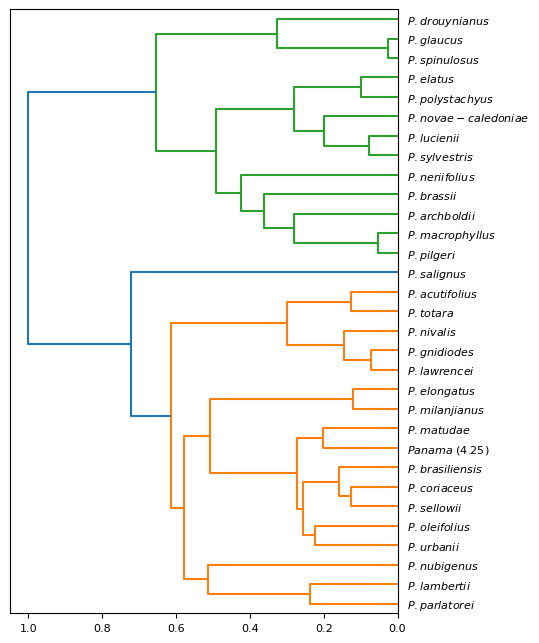

In [29]:
# Pass the pseudonovel images to the MLP

import torch
import pandas as pd

X_train_pseudonovel = torch.tensor(df_Features_Unknown.values)

X_train_novel= X_train_pseudonovel
print(X_train_pseudonovel.shape)
Genus_List_With_Pseudonovel = GenusList + ["$\it{Panama}$ (4.25)"]

len(Genus_List_With_Pseudonovel)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train_novel = X_train_novel.to(device)
output = best_model(X_train.float())
output_novel = best_model(X_train_novel.reshape(X_train_novel.shape[0],1,X_train_novel.shape[1]).float())
output_novel.shape
Dataset_With_Known_And_Novel = torch.vstack((output, output_novel))
Dataset_With_Known_And_Novel.shape

# k + n scheme
# Average all features per known species

Species_Index = Y;
NumericSpeciesIndex = pd.to_numeric(Species_Index);
Indices_and_Features = np.column_stack((NumericSpeciesIndex, output.cpu().detach().numpy()));
df = pd.DataFrame(data=Indices_and_Features)
Per_Species_Transformed_Features = df.groupby([0,]).mean()
Per_Species_Transformed_Features;

NumericSpeciesIndexNovel  = ["$\it{Panama}$ (4.25)"]

Indices_and_Features_Novel = np.column_stack((NumericSpeciesIndexNovel, output_novel.cpu().detach().numpy()));
df_novel = pd.DataFrame(data= Indices_and_Features_Novel)
df_novel.groupby(by=0,axis = 0)

df_known_averaged_and_Novel = pd.concat([Per_Species_Transformed_Features,df_novel])
df_known_averaged_and_Novel  = df_known_averaged_and_Novel.iloc[: , 1:]

#  Obtain predicted cladogram (phylogenetic tree) with the placement of the pseudo-novel specimens 
import matplotlib
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

df_known_averaged_and_Novel_norm = (df_known_averaged_and_Novel-df_known_averaged_and_Novel.min())/(df_known_averaged_and_Novel.max()-df_known_averaged_and_Novel.min())
linked = linkage(df_known_averaged_and_Novel, "average", metric = "cosine")

Genera = ["$\it{P. acutifolius}$","$\it{P. archboldii}$","$\it{P. brasiliensis}$","$\it{P. brassii}$","$\it{P. coriaceus}$","$\it{P. drouynianus}$","$\it{P. elatus}$","$\it{P. elongatus}$","$\it{P. glaucus}$","$\it{P. gnidiodes}$","$\it{P. lambertii}$","$\it{P. lawrencei}$","$\it{P. lucienii}$","$\it{P. macrophyllus}$","$\it{P. matudae}$","$\it{P. milanjianus}$","$\it{P. neriifolius}$","$\it{P. nivalis}$","$\it{P. novae-caledoniae}$","$\it{P. nubigenus}$","$\it{P. oleifolius}$","$\it{P. parlatorei}$","$\it{P. pilgeri}$","$\it{P. polystachyus}$","$\it{P. salignus}$","$\it{P. sellowii}$","$\it{P. spinulosus}$","$\it{P. sylvestris}$","$\it{P. totara}$","$\it{P. urbanii}$","$\it{Panama}$ (4.25)"];

labelList = Genera
plt.figure(figsize=(5, 8), dpi = 100)
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8) 
dendrogram(linked,
            orientation='left',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.savefig("Fossil_placement_Panama_4.25.pdf", bbox_inches = "tight")

In [ ]:
# Compute and save cosine dissimilarity matrix as csv file. This matrix depicts distances separating the fossil specimen from the known taxa.
Feature_Matrix_Known_and_Unknown = np.array(df_known_averaged_and_Novel)
Feature_Matrix_Known_and_Unknown = Feature_Matrix_Known_and_Unknown.astype(float)
Feature_Matrix_Known_and_Unknown = torch.tensor(Feature_Matrix_Known_and_Unknown)
Feature_Matrix_Known_and_Unknown_dist = 1-sim_matrix(Feature_Matrix_Known_and_Unknown,Feature_Matrix_Known_and_Unknown)
np.savetxt(absolute_path + "/dist_matrix_fossil_placement.csv", Feature_Matrix_Known_and_Unknown_dist, delimiter=",")